In [167]:
import time
import sys
import csv
import requests
from icecream import ic
from jsonpath import jsonpath
import pandas as pd
import numpy as np

from collections import Counter

# 正则
import re

# 词云
import stylecloud
from stylecloud import gen_stylecloud
import jieba
jieba.setLogLevel(jieba.logging.INFO)

# 相关性
import seaborn as sns
import matplotlib.pyplot as plt
# solve err
sns.set_style("darkgrid",{"font.sans-serif":['KaiTi', 'Arial']})

## 评论区数据整理

In [19]:
comment_fname = r"D:/Study/GitHub/MyProject/bilibili-BAC/data/Comment.csv"
comment = pd.read_csv(comment_fname,sep=',',engine='python',header=None)
comment.columns =["昵称","性别","签名","回复数","点赞数","评论内容","等级","评论时间"]
comment

,昵称,性别,签名,回复数,点赞数,评论内容,等级,评论时间
0,Seeflsch,保密,：D,41,2320,给大家解释一下为啥看舌尖第一二季都不要看第三季：\n第一二季的导演均为陈晓卿，整个舌尖的灵感...,5,20200814
1,没有斧头の河神,男,摸鱼闲聊群560697422（已经社畜，咕）,47,2272,直接看最后一集，这样我就是最先看完的了[妙啊][妙啊][妙啊],5,20200813
2,-夢見系人失-,保密,Forward! To the mysterious future!,39,1138,第二季啥时候安排[doge]第三季就不用了,5,20200813
3,尧文兮兮,保密,。。。,9,836,怀念高中班主任晚自习放舌尖上的中国的温馨时刻，黑漆漆的后排传来窸窸窣窣的交换零食声，啊～青春...,5,20200813
4,带带大RX,保密,NaN,37,513,可惜后面的续作又很难达到第一季的高度了，唏嘘。,2,20200813
...,...,...,...,...,...,...,...,...
395,梦幻雪米拉比,保密,NaN,0,0,第二季真的绝[doge],4,20200813
396,草丛三宝,保密,天天都在期待世界末日,0,0,第二季安排一下吧，卖刀的广告和qj爱情就不用安排了[doge],5,20200813
397,小羊小羊几点咯,女,NaN,0,0,舌尖上的中国。\n是妈妈的焖面，油焖大虾，糖醋小排，可乐鸡翅……是奶奶的糖醋鱼，红烧肉，鱼香...,4,20200813
398,雾漫小东江_,男,及时止损.,0,0,来力来力,4,20200813


### 计算男女会员等级差异

In [61]:
sex_group = comment.groupby("性别", axis=0)
print("男生: 平均值为: {:.2f}，方差为: {:.2f}"
      .format(sex_group.get_group("男")["等级"].mean(), sex_group.get_group("男")["等级"].var()))
print("女生: 平均值为: {:.2f}，方差为: {:.2f}"
      .format(sex_group.get_group("女")["等级"].mean(), sex_group.get_group("女")["等级"].var()))

男生: 平均值为: 4.99，方差为: 0.63
女生: 平均值为: 4.84，方差为: 0.75


### 会员等级和回复度，点赞数关系

In [62]:
comment.pivot_table(index='等级',values=['昵称','点赞数','回复数'],aggfunc='mean').sort_values(by='等级', ascending=False)

,回复数,点赞数
等级,,
6,0.306667,10.093333
5,1.873786,78.485437
4,1.138298,19.755319
3,0.312500,2.625000
2,9.375000,128.625000
0,0.000000,1.000000


In [63]:
comment.pivot_table(index='昵称',values=['回复数','点赞数'],aggfunc='sum').sort_values(by='回复数', ascending=False)

,回复数,点赞数
昵称,,
Seeflsch,102,5016
没有斧头の河神,94,4544
-夢見系人失-,78,2276
带带大RX,74,1026
美国人失掉自信了吗,70,476
...,...,...
啊啊啊哈哈哈嗝嗝嗝,0,0
唯有向日葵,0,0
哲修master,0,0


### 针对多次评论的异常账户分析

In [60]:
pd.concat(g for _, g in comment.groupby("昵称") if len(g) > 2)

,昵称,性别,签名,回复数,点赞数,评论内容,等级,评论时间
0,Seeflsch,保密,：D,41,2320,给大家解释一下为啥看舌尖第一二季都不要看第三季：\n第一二季的导演均为陈晓卿，整个舌尖的灵感...,5,20200814
10,Seeflsch,保密,：D,10,188,真的太棒了，之前老师说我们这一代完全不懂什么是美食我还不以为然，每天吃快餐食品不亦乐乎，但是...,5,20200814
20,Seeflsch,保密,：D,41,2320,给大家解释一下为啥看舌尖第一二季都不要看第三季：\n第一二季的导演均为陈晓卿，整个舌尖的灵感...,5,20200814
30,Seeflsch,保密,：D,10,188,真的太棒了，之前老师说我们这一代完全不懂什么是美食我还不以为然，每天吃快餐食品不亦乐乎，但是...,5,20200814
315,一只鸭子Z,保密,NaN,0,0,看完了，,5,20200820
316,一只鸭子Z,保密,NaN,0,0,我是纪录菌欧。,5,20200820
317,一只鸭子Z,保密,NaN,0,0,好吃,5,20200820
252,猜到了刚刚好,男,我是新人，请多多支持吖。,0,0,[热词系列_爷青回][热词系列_知识增加][热词系列_好家伙][热词系列_芜湖起飞][热,4,20210101
253,猜到了刚刚好,男,我是新人，请多多支持吖。,0,0,【doge】,4,20210101
254,猜到了刚刚好,男,我是新人，请多多支持吖。,0,0,[妙啊][妙啊][妙啊],4,20210101


### 评论区数据点赞数排序

In [75]:
mean_ratings = comment.pivot_table(index='昵称',values=['回复数','点赞数']).sort_values(by='点赞数', ascending=False)
mean_ratings.head(10)

,回复数,点赞数
昵称,,
没有斧头の河神,47.0,2272.0
Seeflsch,25.5,1254.0
-夢見系人失-,39.0,1138.0
尧文兮兮,9.0,836.0
带带大RX,37.0,513.0
无声千岛酱,9.0,443.0
柴犬腿长两米八,5.0,292.0
美国人失掉自信了吗,35.0,238.0
毛熊-拜阳零峰,3.0,221.0


### 评论区热图

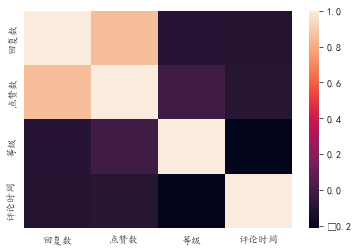

In [78]:
correlations = comment.corr()
sns.heatmap(correlations)
plt.show()

### 评论内容字符数大小

In [81]:
a = b = c = d = 0
for i in range(len(comment['评论内容'])):
    n = len(comment['评论内容'][i])
    if 0 < n < 20:
        a+=1
    elif 20 <= n < 50:
        b+=1
    elif 50 <= n < 100:
        c+=1
    else :
        d+=1
print("评论内容字符数大小统计：\n字符数小于20的有：\t{}个\t占比{:.2f}\n字符数20<=n<50的有：\t{}个\t占比{:.2f}\n字符数50<=n<100的有：\t{}个\t占比{:.2f}\n字符数大于100的有：\t{}个\t占比{:.2f}\n".format(a,a/i,b,b/i,c,c/i,d,d/i))

评论内容字符数大小统计：
字符数小于20的有：	220个	占比0.55
字符数20<=n<50的有：	122个	占比0.31
字符数50<=n<100的有：	36个	占比0.09
字符数大于100的有：	22个	占比0.06



### 评论关键字频率云图

In [145]:
file_name= "D:/Study/GitHub/MyProject/bilibili-BAC/data/Comment.csv"
with open(file_name,'r',encoding='utf-8') as f:
    word_list = jieba.cut(f.read())
    result = " ".join(word_list) # 分词用 隔开
    # 制作中文云词
    gen_stylecloud(text=result,
                   font_path='C:\\Windows\\Fonts\\simhei.ttf',
                   output_name='D:/Study/GitHub/MyProject/bilibili-BAC/data/Comment.png',
                   icon_name='fas fa-bell'
                   ) # 必须加中文字体，否则格式错误

### 评论区表情包数据整理

In [83]:
# 数据处理
emoji_list = []
for i in range(len(comment['评论内容'])):
    temp = re.findall('\[(.*?)\]',comment['评论内容'][i])
    if(len(temp)!=0):
        emoji_list.append(temp[0])
print(emoji_list)

['妙啊', 'doge', '妙啊', '热词系列_锤', 'doge', 'tv_微笑', '酸了', 'doge', 'doge', '妙啊', '笑哭', '妙啊', 'doge', '妙啊', '热词系列_锤', 'doge', 'tv_微笑', '酸了', 'doge', 'doge', '妙啊', '笑哭', '打call', 'doge', '笑哭', '呲牙', '打call', '笑哭', '思考', '笑哭', '藏狐', 'doge', 'doge', '辣眼睛', '热词系列_完结撒花', '喜欢', 'doge', '微笑', '洛天依_耶', 'doge', '辣眼睛', 'doge', '支持', 'doge', '热词系列_知识增加', 'doge', '拥抱', '呲牙', '无语', '妙啊', 'doge', 'doge', '热词系列_三连', 'doge', 'doge', 'doge', '爱心', '大哭', 'doge', '偷笑', 'doge', 'OK', 'OK', '辣眼睛', '滑稽-圣诞', '热词系列_泪目', 'doge', '胜利', '捂眼', '惊喜', 'Cat_hibye', '大哭', '吐', 'doge', '打call', '辣眼睛', 'doge', '灵魂出窍', 'tv_doge', '害羞', 'doge', '拥抱', '热词系列_害怕', '热词系列_真香', 'doge', 'doge', '呲牙', '热词系列_泪目', 'doge', '妙啊', 'doge', '笑哭', 'doge', 'doge', '大哭', 'doge', '滑稽', 'doge', 'doge', '捂眼', '捂眼', '捂眼', 'doge', '笑哭', '滑稽', '大笑', 'doge', '傲娇', '热词系列_吹爆', 'doge', 'doge', '打call', '蛆音娘_卖萌', 'doge', '爱心', 'tv_鬼脸', '来古-呆滞', '辣眼睛', '捂脸', '吃瓜', '笑哭', 'doge', '妙啊', '热词系列_妙啊', '热词系列_知识增加', '妙啊', 'OK', '热词系列_爷青回', '妙啊', '2021', '打call-圣诞',

### 评论区表情包数据频次分析，找出列表中出现次数最多的元素

In [147]:
# 输出频率最大的n个元素,类型为list
collection_words = Counter(emoji_list)
# print(collection_words)

most_counterNum = collection_words.most_common(5)
print(most_counterNum)

[('doge', 51), ('妙啊', 12), ('笑哭', 9), ('辣眼睛', 6), ('OK', 6)]


### 评论区表情包频次云图

In [84]:
word_list = jieba.cut(emoji_list)
result = " ".join(emoji_list) #分词用 隔开
# 制作中文云词str.join(list)
gen_stylecloud(text=result,
               font_path='C:\\Windows\\Fonts\\simhei.ttf',
               output_name='D:/Study/GitHub/MyProject/bilibili-BAC/data/emoji.png',
               icon_name='fas fa-bell'
               ) #必须加中文字体，否则格式错误

## 弹幕数据整理

In [102]:
barrage_fname = r"D:/Study/GitHub/MyProject/bilibili-BAC/data/Barrage.csv"
barrage = pd.read_csv(barrage_fname,sep=',',engine='python',header=None)

### 弹幕云图

In [151]:
file_name= "D:/Study/GitHub/MyProject/bilibili-BAC/data/Barrage.csv"
with open(file_name,'r',encoding='utf-8') as f:
    word_list = jieba.cut(f.read())
    result = " ".join(word_list) # 分词用 隔开
    # 制作中文云词
    gen_stylecloud(text=result,
                   font_path='C:\\Windows\\Fonts\\simhei.ttf',
                   output_name='D:/Study/GitHub/MyProject/bilibili-BAC/data/Barrage.png',
                   icon_name='fas fa-bell'
                   ) # 必须加中文字体，否则格式错误

### 弹幕字数分析

In [187]:
a = b = c = d = 0

for i in range(barrage.shape[1]):
    n = len(barrage[i].loc[0])
    if 0 < n < 5:
        a+=1
    elif 5 <= n < 10:
        b+=1
    elif 10 <= n < 20:
        c+=1
    else :
        d+=1
print("弹幕内容字符数大小统计：\n字符数小于5的有：\t{}个\t占比{:.2f}\n字符数5<=n<10的有：\t{}个\t占比{:.2f}\n字符数10<=n<20的有：\t{}个\t占比{:.2f}\n字符数大于等于20的有：\t{}个\t占比{:.2f}\n".format(a,a/i,b,b/i,c,c/i,d,d/i))

弹幕内容字符数大小统计：
字符数小于5的有：	528个	占比0.49%
字符数5<=n<10的有：	394个	占比0.36%
字符数10<=n<20的有：	150个	占比0.14%
字符数大于等于20的有：	9个	占比0.01%

